In [1]:
import pickle
from emulator import *
from fisher_utils import *

with open('cluster_abundance_fiducial_covariance.pkl', 'rb') as file:
    cluster_count_cov = pickle.load(file)

In [2]:
# import pickle
# from emulator import *
# from fisher_utils import *

# with open('cluster_abundance_fiducial_covariance_shot_noise_only.pkl', 'rb') as file:
#     cluster_count_cov = pickle.load(file)

In [3]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]

                
                
from scipy.linalg import cho_factor, cho_solve
cholesky_factor = cho_factor(cov_matrix_2d)
cov_inv = cho_solve(cholesky_factor, np.eye(n_z * n_r))                


In [4]:
# Iterate over the parameters and the corresponding axes
fiducial_log10_rel_step_size = {
    '10^9 As': -2.,
    'ns': -2.4,
    'H0': -2.3,
    'w0': -1.7,
    'ombh2': -2.2,
    'omch2': -2,
    'nu_mass_ev': -1.075,
    'sigma8' : -2.
}

In [5]:
dμdθ = {}
for parameter_changed in fiducial_log10_rel_step_size:
    cluster_abundance_pos = None
    cluster_abundance_neg = None
    log10_rel_step_size = fiducial_log10_rel_step_size[parameter_changed]
    fname_base = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_fisher_%s_%.4f'%(parameter_changed, log10_rel_step_size)
    with open(fname_base, 'rb') as file:
        cluster_abundance_pos = pickle.load(file)
    with open(fname_base+'_neg', 'rb') as file:
        cluster_abundance_neg = pickle.load(file)
    h = np.abs(fiducial_cosmology[parameter_changed]) * 10**log10_rel_step_size
    tmp_theory_deriv = (cluster_abundance_pos - cluster_abundance_neg) / (2 * h)
    flattened_theory_deriv = np.zeros((n_z * n_r))
    for i in range(n_z):
        for a in range(n_r):
            flattened_theory_deriv[i * n_r + a] = tmp_theory_deriv[i, a]
    dμdθ[parameter_changed] = flattened_theory_deriv


In [6]:
n_parameters = len(fiducial_cosmology.keys())

fisher_matrix = np.zeros((n_parameters, n_parameters))

nu_mass_ev_idx = -1
for i, θi in enumerate(fiducial_cosmology.keys()):
    print(i, θi)
    if(θi == 'nu_mass_ev'):
        nu_mass_ev_idx = i
    for j, θj in enumerate(fiducial_cosmology.keys()):
        dμl_θi = dμdθ[θi]
        dμm_θj = dμdθ[θj]
        fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)

0 10^9 As
1 ns
2 H0
3 w0
4 ombh2
5 omch2
6 nu_mass_ev
7 sigma8


/tmp/ipykernel_32406/4069367506.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(fisher_matrix), cmap='rainbow')


Text(0.5, 1.0, '$\\log_{10}$Fisher Matrix')

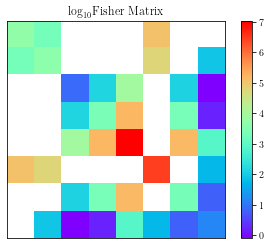

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'

plt.imshow(np.log10(fisher_matrix), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'$\log_{10}$Fisher Matrix')


In [8]:
from scipy.linalg import cho_solve, cho_factor

# Compute the Cholesky decomposition
cholesky_factor = cho_factor(fisher_matrix)

# Solve for the inverse of the diagonal element
e_i = np.zeros_like(fisher_matrix[nu_mass_ev_idx])
e_i[nu_mass_ev_idx] = 1

inv_diagonal_element = cho_solve(cholesky_factor, e_i)[nu_mass_ev_idx]

In [9]:
inv_diagonal_element

9.020182182290739

In [10]:
inv_fisher_matrix = np.linalg.inv(fisher_matrix)


np.sqrt(inv_fisher_matrix[nu_mass_ev_idx][nu_mass_ev_idx])

3.003361813421122

In [12]:
print('%10s\t %25s\t %25s'%('parameter', 'σ(marginalized)/fid val', 'σ(unmarginalized)/fid val'))
print('----------------------------------------------------------------------------')
for i, θi in enumerate(fiducial_cosmology.keys()):
    print('%10s\t %25.1e\t %25.1e'%(θi, np.abs(inv_fisher_matrix[i,i]/fiducial_cosmology[θi]), np.abs(fisher_matrix[i,i]**(-1)/fiducial_cosmology[θi])))

 parameter	   σ(marginalized)/fid val	 σ(unmarginalized)/fid val
----------------------------------------------------------------------------
   10^9 As	                   8.2e-01	                   9.2e-05
        ns	                   3.0e-01	                   2.4e-04
        H0	                   4.0e+01	                   1.9e-03
        w0	                   2.9e+01	                   3.9e-04
     ombh2	                   7.0e-02	                   4.2e-06
     omch2	                   4.4e-02	                   3.0e-06
nu_mass_ev	                   1.3e+02	                   6.6e-03
    sigma8	                   2.9e+01	                   8.4e-02


In [13]:
labels = {
    '10^9 As': r'$10^9A_s$',
    'ns': r'$n_s$',
    'H0': r'$H_0$',
    'w0': r'$w_0$',
    'ombh2': r'$\Omega_b h^2$',
    'omch2': r'$\Omega_c h^2$',
    'nu_mass_ev': r'$\sum m_\nu$',
    'sigma8' : r'$\sigma_8$'
}

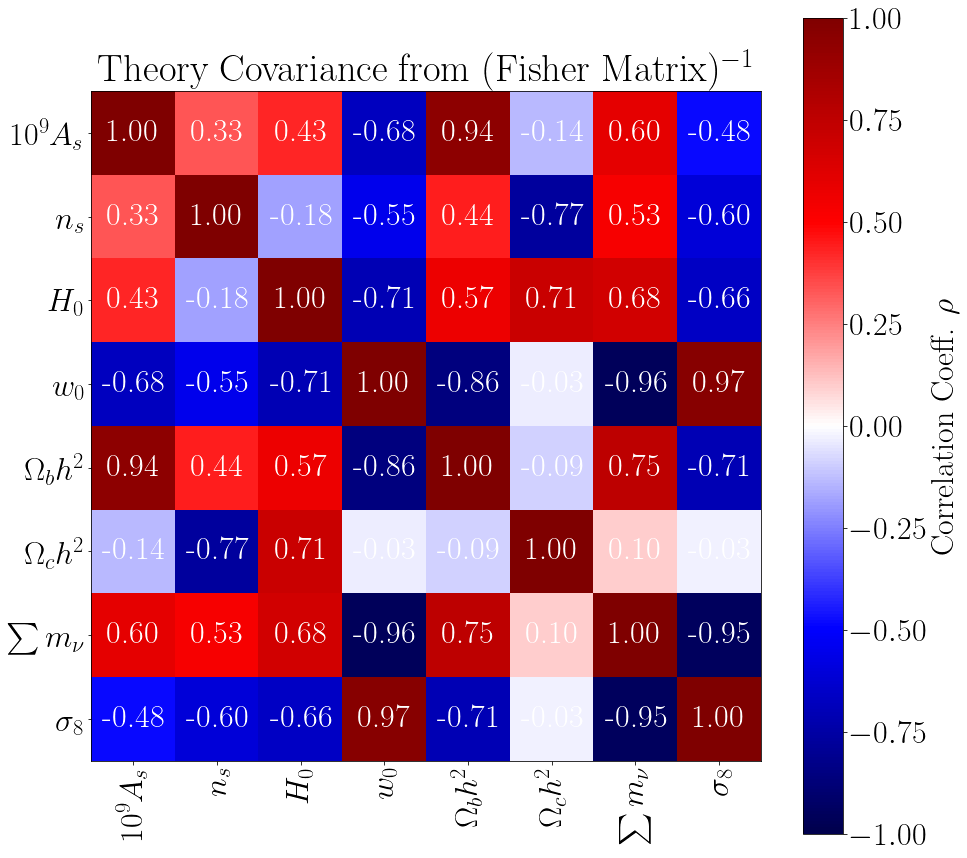

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(15,15))

tmp_theory_cov =(inv_fisher_matrix)

# Compute the diagonal of the covariance matrix
diagonal = np.sqrt(np.diag(tmp_theory_cov))

# Calculate the correlation coefficient matrix
correlation_matrix = tmp_theory_cov / np.outer(diagonal, diagonal)

# Annotate cells with values
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.imshow(correlation_matrix, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar(label=r'Correlation Coeff. $\rho$')

tick_positions = np.arange(len(fiducial_cosmology))
tick_labels = [labels[key] for key in fiducial_cosmology.keys()]

plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.yticks(tick_positions, tick_labels)

plt.title(r'Theory Covariance from (Fisher Matrix)$^{-1}$')
plt.savefig('fisher_forecasted_theory_cov.pdf')